# # # # Blog Feedback Dataset Preprocessing
# # # 
# # # ## Data Preparation Strategy
# # # 
# # # This notebook preprocesses the Blog Feedback dataset, which contains data from blog posts with features extracted from these posts. The target variable is the number of comments the blog post received in the following 24 hours.
# # # 
# # # The preprocessing includes:
# # # 
# # # 1. **Training Set**: Using the provided training split
# # # 2. **Test Set**: Using the provided test split
# # # 3. **Data Visualization**: Exploring the distribution of input features and target variables
# # # 4. **Feature Normalization**: Standardizing the input features for better model performance
# # # 5. **Outlier Analysis**: Identifying and handling outliers in the target variable


# # # %  
# # # % UCI Blog Feedback Dataset Description
# # # %
# # # % The Blog Feedback dataset contains features extracted from blog posts. The task is to predict the number of comments
# # # % a blog post will receive in the next 24 hours after publication.
# # # %
# # # % The dataset contains 280 features, with the target variable being the number of comments in the next 24 hours.
# # # % Features include blog statistics, temporal information, and text-based features.
# # # %
# # # % This is a regression problem with a highly imbalanced target distribution. The dataset consists of 60,021 training
# # # % examples with an imbalanced ratio of approximately 30,000:1.
# # # %     
# # # @RELATION BlogFeedback
# # # 
# # # @ATTRIBUTE [1-50] REAL (Blog source statistics: avg, std, min, max, median of attributes 51-60)
# # # @ATTRIBUTE [51] REAL (Total number of comments before basetime)
# # # @ATTRIBUTE [52] REAL (Number of comments in last 24h before basetime)
# # # @ATTRIBUTE [53] REAL (Number of comments between 48h and 24h before basetime)
# # # @ATTRIBUTE [54] REAL (Number of comments in first 24h after publication but before basetime)
# # # @ATTRIBUTE [55] REAL (Difference between attributes 52 and 53)
# # # @ATTRIBUTE [56-60] REAL (Same as 51-55 but for trackbacks/links instead of comments)
# # # @ATTRIBUTE [61] REAL (Time between publication and basetime)
# # # @ATTRIBUTE [62] REAL (Length of blog post)
# # # @ATTRIBUTE [63-262] REAL (Bag of words features for 200 frequent words)
# # # @ATTRIBUTE [263-269] REAL (Binary indicators for weekday of basetime)
# # # @ATTRIBUTE [270-276] REAL (Binary indicators for weekday of publication)
# # # @ATTRIBUTE [277] REAL (Number of parent pages)
# # # @ATTRIBUTE [278-280] REAL (Min, max, avg number of comments parents received)
# # # @ATTRIBUTE [281] REAL (Target: number of comments in next 24h after basetime)

In [1]:
import os
import pandas as pd
from typing import List, Union, Tuple, Optional, Generator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import gaussian_kde

In [13]:
def generate_blog_headers() -> List[str]:
    """
    Generate header names based on the UCI Blog Feedback dataset attributes description.
    
    Returns:
    --------
    List[str]
        List of column headers for the dataset
    """
    headers = []
    
    # Attributes 1-50: Blog source statistics
    for i in range(1, 51):
        headers.append(f"source_stat_{i}")
    
    # Attributes 51-55: Comment statistics
    headers.append("total_comments_before")
    headers.append("comments_last_24h")
    headers.append("comments_24h_to_48h")
    headers.append("comments_first_24h")
    headers.append("comments_diff_24h")
    
    # Attributes 56-60: Trackback statistics
    headers.append("total_trackbacks_before")
    headers.append("trackbacks_last_24h")
    headers.append("trackbacks_24h_to_48h")
    headers.append("trackbacks_first_24h")
    headers.append("trackbacks_diff_24h")
    
    # Attribute 61-62: Time and length
    headers.append("time_since_publication")
    headers.append("post_length")
    
    # Attributes 63-262: Bag of words
    for i in range(1, 201):
        headers.append(f"word_{i}")
    
    # Attributes 263-269: Weekday of basetime
    for day in ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]:
        headers.append(f"basetime_{day}")
    
    # Attributes 270-276: Weekday of publication
    for day in ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]:
        headers.append(f"publication_{day}")
    
    # Attributes 277-280: Parent statistics
    headers.append("num_parent_pages")
    headers.append("parent_comments_min")
    headers.append("parent_comments_max")
    headers.append("parent_comments_avg")
    
    # Attribute 281: Target
    headers.append("target_comments_next_24h")
    
    return headers

def add_headers_to_blog_files(
    data_dir: str = "data/blog_feedback",
    test_dir: str = "data/blog_feedback/test_set_files",
    backup: bool = True,
    backup_dir: str = "data/blog_feedback/raw",
    verbose: bool = True
) -> None:
    """
    Add appropriate headers to all CSV files in the blog feedback dataset.
    Only adds headers to files that don't already have them.
    
    Parameters:
    -----------
    data_dir : str
        Directory containing the main training file
    test_dir : str
        Directory containing test files
    backup : bool
        If True, create backup of original files before modifying
    backup_dir : str
        Directory to store backup files
    verbose : bool
        If True, print progress information
    """
    # Generate the headers
    headers = generate_blog_headers()
    
    # Get all CSV files
    all_files = []
    
    # Add all training files (not just blogf_train.csv)
    training_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) 
                     if f.endswith(".csv") and os.path.isfile(os.path.join(data_dir, f))]
    all_files.extend(training_files)
    
    # Add test files
    test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(".csv")]
    all_files.extend(test_files)
    
    if verbose:
        print(f"Found {len(all_files)} CSV files to process")
    
    # Create backup directory if it doesn't exist
    if backup and not os.path.exists(backup_dir):
        os.makedirs(backup_dir)
        if verbose:
            print(f"Created backup directory: {backup_dir}")
    
    files_processed = 0
    files_skipped = 0
    
    for i, file_path in enumerate(all_files):
        # Check if file already has headers
        try:
            # Try to read the first few rows to check for headers
            sample_df = pd.read_csv(file_path, nrows=5)
            
            # If the first column has string values that match our expected headers, assume it has headers
            if any(col_name in headers for col_name in sample_df.columns):
                if verbose:
                    print(f"Skipping {file_path} - headers already present")
                files_skipped += 1
                continue
        except Exception as e:
            # If there's an error reading with headers, assume no headers
            pass
        
        # Create backup if requested
        if backup:
            file_name = os.path.basename(file_path)
            backup_path = os.path.join(backup_dir, file_name + ".bak")
            if not os.path.exists(backup_path):
                with open(file_path, 'r') as src, open(backup_path, 'w') as dst:
                    dst.write(src.read())
                if verbose:
                    print(f"Created backup: {backup_path}")
        
        # Read file without headers
        df = pd.read_csv(file_path, header=None)
        
        # Check if the number of columns matches the expected number of headers
        if df.shape[1] != len(headers):
            print(f"Warning: File {file_path} has {df.shape[1]} columns but {len(headers)} headers were generated.")
            # Use a subset of headers or pad with extra headers as needed
            actual_headers = headers[:df.shape[1]] if df.shape[1] < len(headers) else headers + [f"extra_{j}" for j in range(df.shape[1] - len(headers))]
        else:
            actual_headers = headers
        
        # Set the column names
        df.columns = actual_headers
        
        # Save the file with headers
        df.to_csv(file_path, index=False)
        files_processed += 1
        
        if verbose and (i+1) % 10 == 0:
            print(f"Processed {i+1}/{len(all_files)} files...")
    
    if verbose:
        print(f"Added headers to {files_processed} files")
        print(f"Skipped {files_skipped} files that already had headers")
        print("Header addition complete!")

# updating the headers
add_headers_to_blog_files(
    data_dir="C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback",
    test_dir="C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files",
    backup=True,
    backup_dir="C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw",
    verbose=True
)

Found 61 CSV files to process
Created backup: C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw\blogf_train.csv.bak
Skipping C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files\blogData_test-2012.02.01.00_00.csv - headers already present
Skipping C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files\blogData_test-2012.02.02.00_00.csv - headers already present
Skipping C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files\blogData_test-2012.02.03.00_00.csv - headers already present
Skipping C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files\blogData_test-2012.02.04.00_00.csv - headers already present
Skipping C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files\blogData_test-2012.02.05.00_00.csv - headers already present
Skipping C:/Users/the_3/Documents/github/keras-functional-api/data/blog_f

In [14]:
def combine_blog_test_files(
    test_files_dir: str = "data/blog_feedback/test_set_files",
    output_path: str = "data/blog_feedback/blogData_test.csv",
    preserve_date_info: bool = False,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Combine all test files from the UCI Blog Feedback dataset into a single CSV file.
    
    Parameters
    ----------
    test_files_dir : str
        Directory containing the individual test files
    output_path : str
        Path where the combined CSV file will be saved
    preserve_date_info : bool
        If True, adds a 'date' column with the date extracted from the filename
    verbose : bool
        If True, prints progress information
        
    Returns
    -------
    pd.DataFrame
        The combined DataFrame that was saved to the output_path
    """
    # Get list of all test files
    test_files = [f for f in os.listdir(test_files_dir) if f.startswith('blogData_test')]
    
    if verbose:
        print(f"Found {len(test_files)} test files to combine")
    
    # Initialize an empty list to store individual dataframes
    dfs = []
    total_rows = 0
    expected_columns = None
    
    # Process each test file
    for i, file in enumerate(test_files):
        # Construct the full path to the file
        file_path = os.path.join(test_files_dir, file)
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(file_path)
        
        # Print the shape of each file being processed
        if verbose:
            print(f"File {i+1}: {file} - Shape: {df.shape[0]} rows x {df.shape[1]} columns")
        
        # Keep track of total rows
        total_rows += df.shape[0]
        
        # Check if columns are consistent
        if expected_columns is None:
            expected_columns = df.shape[1]
        elif expected_columns != df.shape[1]:
            print(f"Warning: Column count mismatch in file {file}. Expected {expected_columns}, got {df.shape[1]}")
        
        # If requested, extract date from filename and add as a column
        if preserve_date_info:
            # Extract date from filename (e.g., 'blogData_test-2012.02.01.00_00.csv' -> '2012.02.01')
            date_str = file.split('-')[1].split('.00_00')[0]
            df['date'] = date_str
        
        # Append to our list of dataframes
        dfs.append(df)
        
        if verbose and (i+1) % 10 == 0:
            print(f"Processed {i+1}/{len(test_files)} files...")
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    if verbose:
        print(f"Combined dataset shape: {combined_df.shape[0]} rows x {combined_df.shape[1]} columns")
        
        # Check if the total number of rows match
        if total_rows == combined_df.shape[0]:
            print(f"Row count verification: Success! Total individual rows ({total_rows}) matches combined dataset rows ({combined_df.shape[0]})")
        else:
            print(f"Row count verification: Failed! Total individual rows ({total_rows}) does not match combined dataset rows ({combined_df.shape[0]})")
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save the combined dataframe to CSV
    combined_df.to_csv(output_path, index=False)
    
    if verbose:
        print(f"Combined dataset saved to: {output_path}")
    
    return combined_df

In [15]:
# I need to combine the test files into a single csv file first
combined_test_data = combine_blog_test_files(
    test_files_dir="C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/test_set_files", 
    output_path="C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_test.csv"
)

Found 60 test files to combine
File 1: blogData_test-2012.02.01.00_00.csv - Shape: 115 rows x 281 columns
File 2: blogData_test-2012.02.02.00_00.csv - Shape: 133 rows x 281 columns
File 3: blogData_test-2012.02.03.00_00.csv - Shape: 116 rows x 281 columns
File 4: blogData_test-2012.02.04.00_00.csv - Shape: 103 rows x 281 columns
File 5: blogData_test-2012.02.05.00_00.csv - Shape: 92 rows x 281 columns
File 6: blogData_test-2012.02.06.00_00.csv - Shape: 83 rows x 281 columns
File 7: blogData_test-2012.02.07.00_00.csv - Shape: 135 rows x 281 columns
File 8: blogData_test-2012.02.08.00_00.csv - Shape: 155 rows x 281 columns
File 9: blogData_test-2012.02.09.00_00.csv - Shape: 181 rows x 281 columns
File 10: blogData_test-2012.02.10.00_00.csv - Shape: 141 rows x 281 columns
Processed 10/60 files...
File 11: blogData_test-2012.02.11.00_00.csv - Shape: 128 rows x 281 columns
File 12: blogData_test-2012.02.12.00_00.csv - Shape: 101 rows x 281 columns
File 13: blogData_test-2012.02.13.00_00.csv

In [71]:
BLOGF_PATH = 'C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw/blogf_train_unprocessed.csv'
BLOGF_TEST_PATH = 'C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw/blogf_test_unprocessed.csv'

In [72]:
def analyze_dataframe(df: pd.DataFrame) -> None:
    """
    Analyze a dataframe by printing its dimensions, column names, and statistics for each column.
    
    Parameters:
    - df (pd.DataFrame): The dataframe to analyze
    
    Returns:
    - None: This function only prints information, it doesn't return any values
    """
    # --- Get dataset dimensions ---
    num_rows, num_cols = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_cols}")

    # --- Get column names with statistics ---
    print("\n--- Column Names and Statistics ---")
    for col in sorted(df.columns):
        # Get the original index of the column
        original_idx = df.columns.get_loc(col)
        stats = []
        try:
            # Attempt to get min/max - might fail for non-numeric/non-comparable types
            min_val = df[col].min()
            max_val = df[col].max()
            stats.append(f"Min: {min_val}")
            stats.append(f"Max: {max_val}")
        except TypeError:
            stats.append("Min/Max: NA")

        # Get unique count - works for most types
        unique_count = df[col].nunique()
        stats.append(f"Unique: {unique_count}")
        
        # Display column original index, name with its statistics on the same line
        print(f"{original_idx:3d} - {col:<25} | {' | '.join(stats)}")


# Load and analyze the dataset
try:
    # Load the dataset from the specified path
    df = pd.read_csv(BLOGF_PATH)
    df_test = pd.read_csv(BLOGF_TEST_PATH)
    
    # Analyze the loaded dataframe
    analyze_dataframe(df)
    analyze_dataframe(df_test)
    
except FileNotFoundError:
    print(f"Error: File not found at '{BLOGF_PATH}'. Please provide the correct file path.")
except Exception as e:
    print(f"An error occurred: {e}")

Number of rows: 52397
Number of columns: 281

--- Column Names and Statistics ---
266 - basetime_friday           | Min: 0.0 | Max: 1.0 | Unique: 2
262 - basetime_monday           | Min: 0.0 | Max: 1.0 | Unique: 2
267 - basetime_saturday         | Min: 0.0 | Max: 1.0 | Unique: 2
268 - basetime_sunday           | Min: 0.0 | Max: 1.0 | Unique: 2
265 - basetime_thursday         | Min: 0.0 | Max: 1.0 | Unique: 2
263 - basetime_tuesday          | Min: 0.0 | Max: 1.0 | Unique: 2
264 - basetime_wednesday        | Min: 0.0 | Max: 1.0 | Unique: 2
 52 - comments_24h_to_48h       | Min: 0.0 | Max: 1424.0 | Unique: 569
 54 - comments_diff_24h         | Min: -1256.0 | Max: 1422.0 | Unique: 1021
 53 - comments_first_24h        | Min: 0.0 | Max: 1932.0 | Unique: 677
 51 - comments_last_24h         | Min: 0.0 | Max: 1424.0 | Unique: 579
276 - num_parent_pages          | Min: 0.0 | Max: 136.0 | Unique: 22
279 - parent_comments_avg       | Min: 0.0 | Max: 1778.0 | Unique: 266
278 - parent_comments_max  

In [75]:
def preprocess_blog_features(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    target_col: str = "target_comments_next_24h"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Preprocess the UCI Blog Feedback dataset features.
    
    Parameters:
    -----------
    train_df : pd.DataFrame
        The training dataframe to preprocess
    test_df : pd.DataFrame
        The test dataframe to preprocess
    target_col : str
        The name of the target column
        
    Returns:
    --------
    tuple[pd.DataFrame, pd.DataFrame]
        The complete preprocessed training and test dataframes with log10-transformed target included
    """
    print(f"Starting preprocessing - Training shape: {train_df.shape}, Test shape: {test_df.shape}")
    
    # Extract and log10-transform targets
    y_train = np.log10(train_df[target_col] + 1)  # log10(x+1) to handle zeros
    y_test = np.log10(test_df[target_col] + 1)
    print(f"Target log10-transformed. Range: [{y_train.min():.3f}, {y_train.max():.3f}]")
    
    # Initialize dictionaries to store preprocessed features
    train_preprocessed = {}
    test_preprocessed = {}
    
    # Identify feature types based on column properties
    binary_features = []
    sparse_binary_features = []  # For features with <5% ones
    small_gap_features = []
    large_gap_features = []
    dropped_features = []
    
    # Analyze all columns except the target
    all_columns = [col for col in train_df.columns if col != target_col]
    
    for col in all_columns:
        # Skip if column doesn't exist in test set
        if col not in test_df.columns:
            dropped_features.append(col)
            continue
        
        # Get value range
        train_min = train_df[col].min()
        train_max = train_df[col].max()
        train_gap = train_max - train_min
        train_unique = train_df[col].nunique()
        
        test_unique = test_df[col].nunique()
        
        # Drop features without variation in training set
        if train_unique == 1:
            dropped_features.append(col)
            continue
        
        # Identify binary features (exactly 2 unique values)
        if train_unique == 2 and test_unique <= 2:
            # Check if it's a sparse binary feature
            value_counts = train_df[col].value_counts(normalize=True)
            if min(value_counts) < 0.05:
                sparse_binary_features.append(col)
            else:
                binary_features.append(col)
        # Identify features with small gap (< 50)
        elif train_gap < 50:
            small_gap_features.append(col)
        # Features with large gap (>= 50)
        else:
            large_gap_features.append(col)
    
    print(f"Feature categorization complete:")
    print(f" - Binary features: {len(binary_features)}")
    print(f" - Sparse binary features: {len(sparse_binary_features)}")
    print(f" - Small gap features: {len(small_gap_features)}")
    print(f" - Large gap features: {len(large_gap_features)}")
    print(f" - Dropped features: {len(dropped_features)}")
    
    # Process binary and sparse binary features (keep as is)
    for col in binary_features + sparse_binary_features:
        train_preprocessed[col] = train_df[col]
        test_preprocessed[col] = test_df[col]
    
    # Process small gap features (direct min-max normalization)
    for col in small_gap_features:
        # Use training data only for normalization parameters
        min_val = train_df[col].min()
        max_val = train_df[col].max()
        
        # Handle the case where min equals max
        if min_val == max_val:
            dropped_features.append(col)
            continue
        
        train_preprocessed[f"{col}_norm"] = (train_df[col] - min_val) / (max_val - min_val)
        test_preprocessed[f"{col}_norm"] = (test_df[col] - min_val) / (max_val - min_val)
        
        # Clip test values to [0,1] range in case test has values outside training range
        test_preprocessed[f"{col}_norm"] = test_preprocessed[f"{col}_norm"].clip(0, 1)
    
    # Process large gap features (log transform + normalization)
    for col in large_gap_features:
        # Handle negative values using training data only
        min_val = train_df[col].min()
        
        # Handle negative values - shift to non-negative, then apply log10
        if min_val < 0:
            # Shift values so minimum becomes 0, then apply log10
            log_train = np.log10(train_df[col] - min_val + 1)  # +1 to handle zeros
            log_test = np.log10(test_df[col] - min_val + 1)
        else:
            # Use log10(x+1) to handle potential zeros
            log_train = np.log10(train_df[col] + 1)
            log_test = np.log10(test_df[col] + 1)
        
        # Get normalization parameters from training data only
        log_min = log_train.min()
        log_max = log_train.max()
        
        # Handle the case where min equals max after log transform
        if log_min == log_max:
            dropped_features.append(col)
            continue
        
        train_preprocessed[f"log_{col}_norm"] = (log_train - log_min) / (log_max - log_min)
        test_preprocessed[f"log_{col}_norm"] = (log_test - log_min) / (log_max - log_min)
        
        # Clip test values to [0,1] range in case test has values outside training range
        test_preprocessed[f"log_{col}_norm"] = test_preprocessed[f"log_{col}_norm"].clip(0, 1)
    
    # Convert preprocessed dictionaries to DataFrames
    train_processed_df = pd.DataFrame(train_preprocessed)
    test_processed_df = pd.DataFrame(test_preprocessed)
    
    # Add the log10-transformed target to the dataframes
    train_processed_df['target_log_comments_next_24h'] = y_train
    test_processed_df['target_log_comments_next_24h'] = y_test
    
    print(f"Preprocessing complete!")
    print(f"Processed training features shape: {train_processed_df.shape}")
    print(f"Processed test features shape: {test_processed_df.shape}")
    print(f"Total features dropped: {len(dropped_features)}")
    
    return train_processed_df, test_processed_df

In [76]:
# preprocess the dataset
preprocessed_df_train, preprocessed_df_test = preprocess_blog_features(
    train_df=df,
    test_df=df_test,
    target_col='target_comments_next_24h'
)

# print the statistics of the preprocessed dataframe
analyze_dataframe(preprocessed_df_train)
analyze_dataframe(preprocessed_df_test)


Starting preprocessing - Training shape: (52397, 281), Test shape: (7624, 281)
Target log10-transformed. Range: [0.000, 3.154]
Feature categorization complete:
 - Binary features: 57
 - Sparse binary features: 157
 - Small gap features: 30
 - Large gap features: 32
 - Dropped features: 4
Preprocessing complete!
Processed training features shape: (52397, 277)
Processed test features shape: (7624, 277)
Total features dropped: 4
Number of rows: 52397
Number of columns: 277

--- Column Names and Statistics ---
 47 - basetime_friday           | Min: 0.0 | Max: 1.0 | Unique: 2
 43 - basetime_monday           | Min: 0.0 | Max: 1.0 | Unique: 2
 48 - basetime_saturday         | Min: 0.0 | Max: 1.0 | Unique: 2
 49 - basetime_sunday           | Min: 0.0 | Max: 1.0 | Unique: 2
 46 - basetime_thursday         | Min: 0.0 | Max: 1.0 | Unique: 2
 44 - basetime_tuesday          | Min: 0.0 | Max: 1.0 | Unique: 2
 45 - basetime_wednesday        | Min: 0.0 | Max: 1.0 | Unique: 2
268 - log_comments_24h_to_

In [77]:
def save_and_verify_dataset(
    df: pd.DataFrame, 
    output_path: str, 
    dataset_name: str = "Dataset", 
    target_column: str = "target_log_comments_next_24h",
    verify: bool = True
) -> pd.DataFrame:
    """
    Save a dataframe to CSV and optionally verify it was saved correctly.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe to save
    output_path : str
        Path where the CSV file should be saved
    dataset_name : str, optional
        Name of the dataset for display in verification messages
    target_column : str, optional
        Name of the target column to verify its position
    verify : bool, optional
        Whether to load and verify the saved file
        
    Returns:
    --------
    pd.DataFrame
        The loaded dataframe if verify=True, otherwise None
    """
    # Save the dataframe to CSV
    df.to_csv(output_path, index=False)
    print(f"{dataset_name} saved to: {output_path}")
    
    if not verify:
        return None
    
    # Load the saved CSV file to verify it was saved correctly
    loaded_df = pd.read_csv(output_path)
    print(f"\nLoaded {dataset_name.lower()} from: {output_path}")
    print(f"Shape of loaded {dataset_name.lower()}: {loaded_df.shape}")
    
    # Analyze the loaded dataframe to verify preprocessing was successful
    print(f"\nAnalysis of the loaded {dataset_name.lower()}:")
    analyze_dataframe(loaded_df)
    
    # Verify that the target column is the last column
    print(f"\nVerifying target column position for {dataset_name.lower()}:")
    print(f"Last column in loaded {dataset_name.lower()}: {loaded_df.columns[-1]}")
    
    if loaded_df.columns[-1] == target_column:
        print(f"✓ Target column '{target_column}' is correctly positioned as the last column")
    else:
        print(f"✗ Target column '{target_column}' is not in the expected position")
    
    return loaded_df

In [79]:
# Rearrange columns to place ln_peak_intensity last
cols = [col for col in preprocessed_df_train.columns if col != 'target_log_comments_next_24h']
cols.append('target_log_comments_next_24h')
preprocessed_df_train = preprocessed_df_train[cols]

# Define the output path in the same directory as the original file
output_dir = os.path.dirname(BLOGF_PATH)
output_path = os.path.join(output_dir, 'blogf_training.csv')

# Print column order before saving
print("\nColumns in the file (last one is the target):")
print(', '.join(cols))

# Save and verify the dataset using the function
loaded_df = save_and_verify_dataset(
    df=preprocessed_df_train,
    output_path=output_path,
    dataset_name="Preprocessed data",
    target_column="target_log_comments_next_24h",
    verify=True
)

# Now to the test dataset
# Rearrange columns to place ln_peak_intensity last
cols = [col for col in preprocessed_df_test.columns if col != 'target_log_comments_next_24h']
cols.append('target_log_comments_next_24h')
preprocessed_df_test = preprocessed_df_test[cols]

# Define the output path in the same directory as the original file
output_dir = os.path.dirname(BLOGF_PATH)
test_output_path = os.path.join(output_dir, 'blogf_testing.csv')

# Print column order before saving
print("\nColumns in the file (last one is the target):")
print(', '.join(cols))

# Save and verify the dataset using the function
loaded_df = save_and_verify_dataset(
    df=preprocessed_df_test,
    output_path=test_output_path,
    dataset_name="Preprocessed data",
    target_column="target_log_comments_next_24h",
    verify=True
)


Columns in the file (last one is the target):
word_2, word_5, word_6, word_7, word_17, word_27, word_34, word_39, word_40, word_42, word_52, word_53, word_57, word_58, word_60, word_77, word_78, word_79, word_81, word_89, word_96, word_97, word_108, word_118, word_121, word_122, word_129, word_131, word_132, word_135, word_140, word_145, word_148, word_151, word_154, word_164, word_166, word_168, word_170, word_171, word_184, word_185, word_186, basetime_monday, basetime_tuesday, basetime_wednesday, basetime_thursday, basetime_friday, basetime_saturday, basetime_sunday, publication_monday, publication_tuesday, publication_wednesday, publication_thursday, publication_friday, publication_saturday, publication_sunday, word_1, word_3, word_4, word_8, word_9, word_10, word_11, word_12, word_13, word_14, word_15, word_16, word_18, word_19, word_20, word_21, word_22, word_23, word_24, word_25, word_26, word_28, word_29, word_30, word_31, word_32, word_33, word_35, word_36, word_37, word_38, 

In [80]:
def plot_dfs_distr(*dataframes: List[pd.DataFrame], 
                   target_column: str = 'target_log_comments_next_24h',
                   labels: Optional[List[str]] = None, 
                   figsize: Tuple[int, int] = (12, 6), 
                   bins: int = 5) -> None:
    """
    Plot the distribution of a target column for multiple dataframes for comparison.
    
    Parameters:
    -----------
    *dataframes : List[pd.DataFrame]
        Variable number of pandas DataFrames to compare
    target_column : str, default='Torque_1'
        The column name to plot distributions for
    labels : Optional[List[str]], default=None
        List of labels for each dataframe (for the legend)
    figsize : Tuple[int, int], default=(12, 6)
        Tuple specifying figure size (width, height)
    bins : int, default=10
        Number of bins for the histogram
        
    Returns:
    --------
    None
        Displays the plot but doesn't return any value
    """
    # Generate default labels if none provided
    if labels is None:
        labels = [f"DataFrame {i+1}" for i in range(len(dataframes))]
    
    # Create figure with two subplots - KDE and histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Set a different color for each dataframe
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot KDE (Kernel Density Estimation) for each dataframe on the first subplot
    for i, df in enumerate(dataframes):
        sns.kdeplot(
            df[target_column], 
            ax=ax1, 
            label=labels[i], 
            color=colors[i % len(colors)],
            fill=False,  # Don't fill colors on the KDE
            alpha=1.0    # Full opacity for clear lines
        )
    
    # Set titles and labels for KDE plot
    ax1.set_title(f'Density Distribution of {target_column}')
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Plot histograms on the second subplot with non-overlapping bars
    bin_edges = np.linspace(
        min(df[target_column].min() for df in dataframes),
        max(df[target_column].max() for df in dataframes),
        bins + 1
    )
    
    bar_width = (bin_edges[1] - bin_edges[0]) / (len(dataframes) + 0.2)
    
    for i, df in enumerate(dataframes):
        # Calculate histogram values
        hist, _ = np.histogram(df[target_column], bins=bin_edges, density=True)
        # Calculate the center position for each bar group
        bar_positions = bin_edges[:-1] + i * bar_width
        
        ax2.bar(
            bar_positions, 
            hist,
            width=bar_width * 0.9,  # Slightly narrower to create separation
            alpha=0.8, 
            label=labels[i],
            color=colors[i % len(colors)]
        )
    
    # Set titles and labels for histogram
    ax2.set_title(f'Histogram of {target_column}')
    ax2.set_xlabel(target_column)
    ax2.set_ylabel('Normalized Frequency')
    ax2.legend()
    
    # Add descriptive statistics below the plots
    for i, df in enumerate(dataframes):
        stats = (
            f"{labels[i]}: "
            f"Mean={df[target_column].mean():.2f}, "
            f"Median={df[target_column].median():.2f}, "
            f"Min={df[target_column].min():.2f}, "
            f"Max={df[target_column].max():.2f}"
        )
        plt.figtext(0.5, 0.01 - i*0.03, stats, ha='center', fontsize=9)
    
    # Adjust layout to make room for statistics text
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


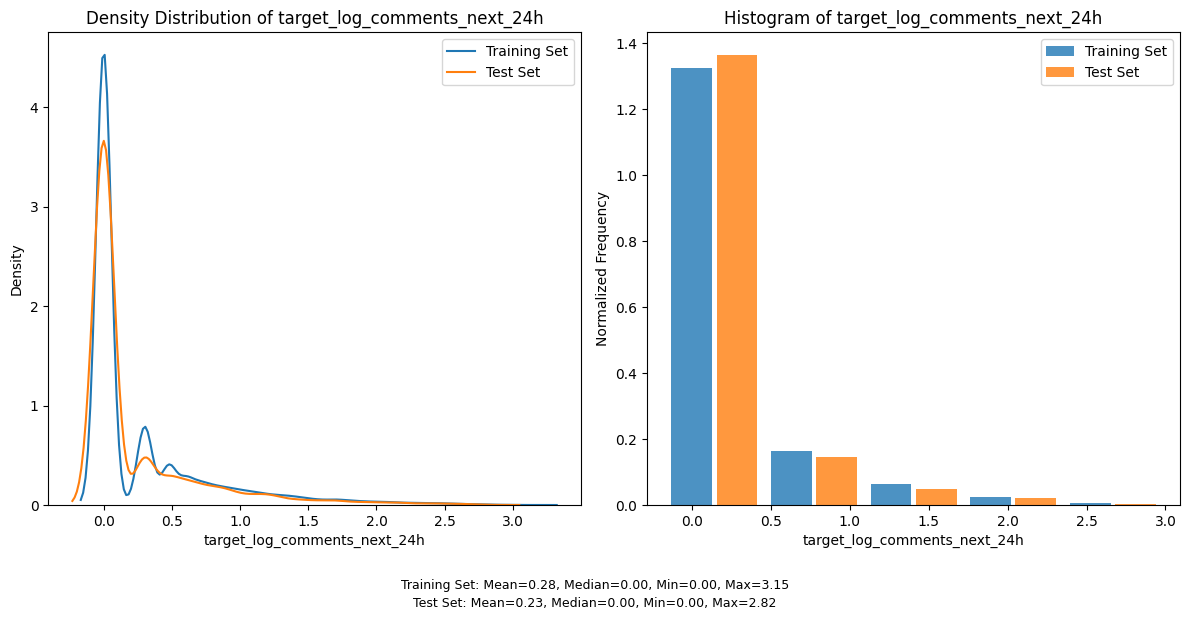

In [81]:
plot_dfs_distr(
    preprocessed_df_train, preprocessed_df_test, 
    target_column='target_log_comments_next_24h',
    labels=['Training Set', 'Test Set'],
    bins=5
)

In [82]:
def create_stratified_kfolds(
    df: pd.DataFrame,
    output_dir: str,
    label_column: str = 'target_log_comments_next_24h',
    n_folds: int = 4,
    seed: int = 42
) -> None:
    """
    Creates stratified k-folds from a dataframe and saves each fold to separate directories.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe to split into folds
    output_dir : str
        Base directory to save the folds
    label_column : str, default='target_log_comments_next_24h'
        Column to use for stratification
    n_folds : int, default=4
        Number of folds to create
    seed : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    None
    """
    np.random.seed(seed)
    print(f"Random seed set to: {seed}")
    
    # Sort the data by labels for stratification
    y = df[label_column].values.reshape(-1, 1)
    sorted_indices = np.argsort(y, axis=0).flatten()
    df_sorted = df.iloc[sorted_indices].reset_index(drop=True)
    
    # Calculate the number of samples and group size
    num_samples = len(df)
    group_size = n_folds  # Each sample will be assigned to one of n_folds groups
    
    # Lists to hold fold indices
    fold_indices = [[] for _ in range(n_folds)]
    
    # Divide samples into groups of n_folds and distribute
    for i in range(0, num_samples, group_size):
        # Get indices for the current group
        group_indices = list(range(i, min(i + group_size, num_samples)))
        
        # If the group is smaller than n_folds, adjust distribution
        if len(group_indices) < group_size:
            # Duplicate some indices to make it equal to group_size
            extended_indices = group_indices * (group_size // len(group_indices) + 1)
            group_indices = extended_indices[:group_size]
        
        # Randomly shuffle the group indices
        np.random.shuffle(group_indices)
        
        # Distribute indices to folds
        for j, idx in enumerate(group_indices):
            if j < len(fold_indices):
                fold_indices[j].append(idx)
    
    # Create all folds and plot distributions
    fold_dfs = []
    all_fold_names = []
    
    # For tracking overall distributions
    all_subtraining_dfs = []
    all_validation_dfs = []
    
    for fold_num in range(n_folds):
        # Select validation indices for this fold
        val_indices = fold_indices[fold_num]
        
        # All other indices go to subtraining
        subtrain_indices = []
        for i in range(n_folds):
            if i != fold_num:
                subtrain_indices.extend(fold_indices[i])
        
        # Create subtraining and validation dataframes
        df_subtrain = df_sorted.iloc[subtrain_indices].reset_index(drop=True)
        df_val = df_sorted.iloc[val_indices].reset_index(drop=True)
        
        # Add to lists for plotting later
        all_subtraining_dfs.append(df_subtrain)
        all_validation_dfs.append(df_val)
        fold_dfs.extend([df_subtrain, df_val])
        all_fold_names.extend([f"Fold {fold_num} - Subtraining", f"Fold {fold_num} - Validation"])
        
        # Create directory for this fold
        fold_dir = os.path.join(output_dir, f"fold{fold_num}")
        os.makedirs(fold_dir, exist_ok=True)
        
        # Save files
        subtrain_path = os.path.join(fold_dir, 'blogf_subtraining.csv')
        val_path = os.path.join(fold_dir, 'blogf_validation.csv')
        
        df_subtrain.to_csv(subtrain_path, index=False)
        df_val.to_csv(val_path, index=False)
        
        # Print statistics
        print(f"\nFold {fold_num}:")
        print(f"Subtraining samples: {len(df_subtrain)} ({len(df_subtrain)/num_samples:.2%})")
        print(f"Validation samples: {len(df_val)} ({len(df_val)/num_samples:.2%})")
        print(f"Subtraining {label_column} range: {df_subtrain[label_column].min():.4f} to {df_subtrain[label_column].max():.4f}")
        print(f"Validation {label_column} range: {df_val[label_column].min():.4f} to {df_val[label_column].max():.4f}")
    
    # Plot distributions - comparing each fold's subtraining and validation to original
    print("\nPlotting distributions...")
    
    # Add original dataframe for comparison
    fold_dfs.insert(0, df)
    all_fold_names.insert(0, "Original Training Data")
    
    # Plot all distributions together
    plot_dfs_distr(*fold_dfs, target_column=label_column, labels=all_fold_names, figsize=(15, 8), bins=5)
    
    # Plot subtraining sets compared to original
    plot_dfs_distr(df, *all_subtraining_dfs, 
                   target_column=label_column, 
                   labels=["Original"] + [f"Fold {i} Subtraining" for i in range(n_folds)],
                   figsize=(15, 8), bins=5)
    
    # Plot validation sets compared to original
    plot_dfs_distr(df, *all_validation_dfs, 
                   target_column=label_column, 
                   labels=["Original"] + [f"Fold {i} Validation" for i in range(n_folds)],
                   figsize=(15, 8), bins=5)
    
    print(f"\nAll {n_folds} folds created and saved to {output_dir}")

Random seed set to: 42

Fold 0:
Subtraining samples: 39300 (75.00%)
Validation samples: 13100 (25.00%)
Subtraining target_log_comments_next_24h range: 0.0000 to 3.1538
Validation target_log_comments_next_24h range: 0.0000 to 3.1538

Fold 1:
Subtraining samples: 39300 (75.00%)
Validation samples: 13100 (25.00%)
Subtraining target_log_comments_next_24h range: 0.0000 to 3.1538
Validation target_log_comments_next_24h range: 0.0000 to 3.1538

Fold 2:
Subtraining samples: 39300 (75.00%)
Validation samples: 13100 (25.00%)
Subtraining target_log_comments_next_24h range: 0.0000 to 3.1538
Validation target_log_comments_next_24h range: 0.0000 to 3.1538

Fold 3:
Subtraining samples: 39300 (75.00%)
Validation samples: 13100 (25.00%)
Subtraining target_log_comments_next_24h range: 0.0000 to 3.1538
Validation target_log_comments_next_24h range: 0.0000 to 3.1538

Plotting distributions...


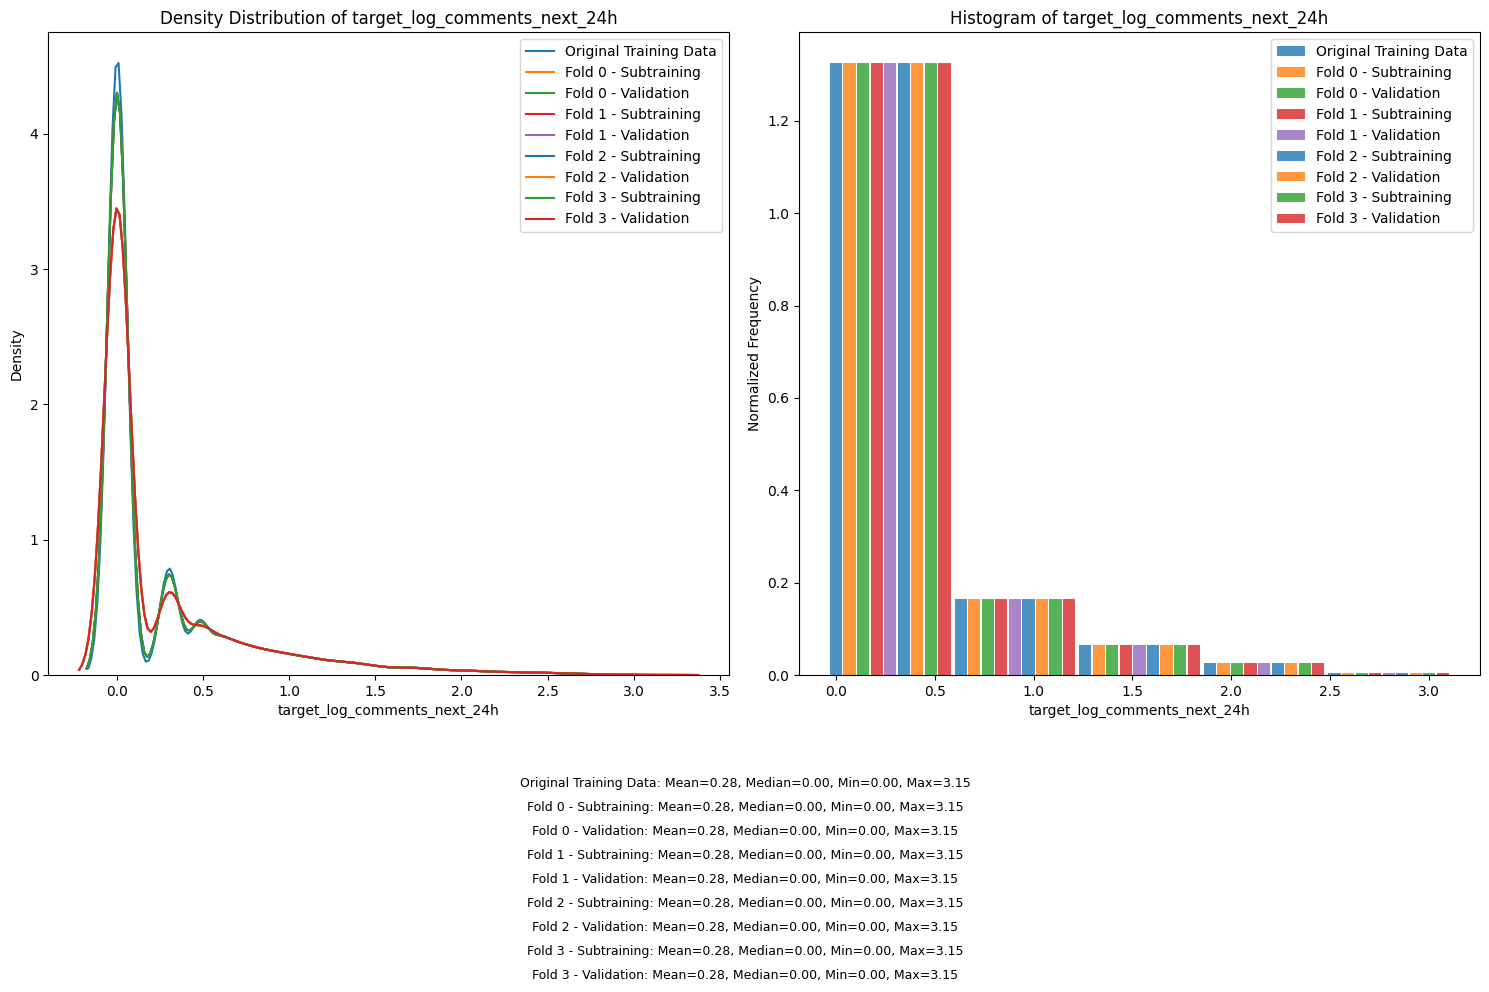

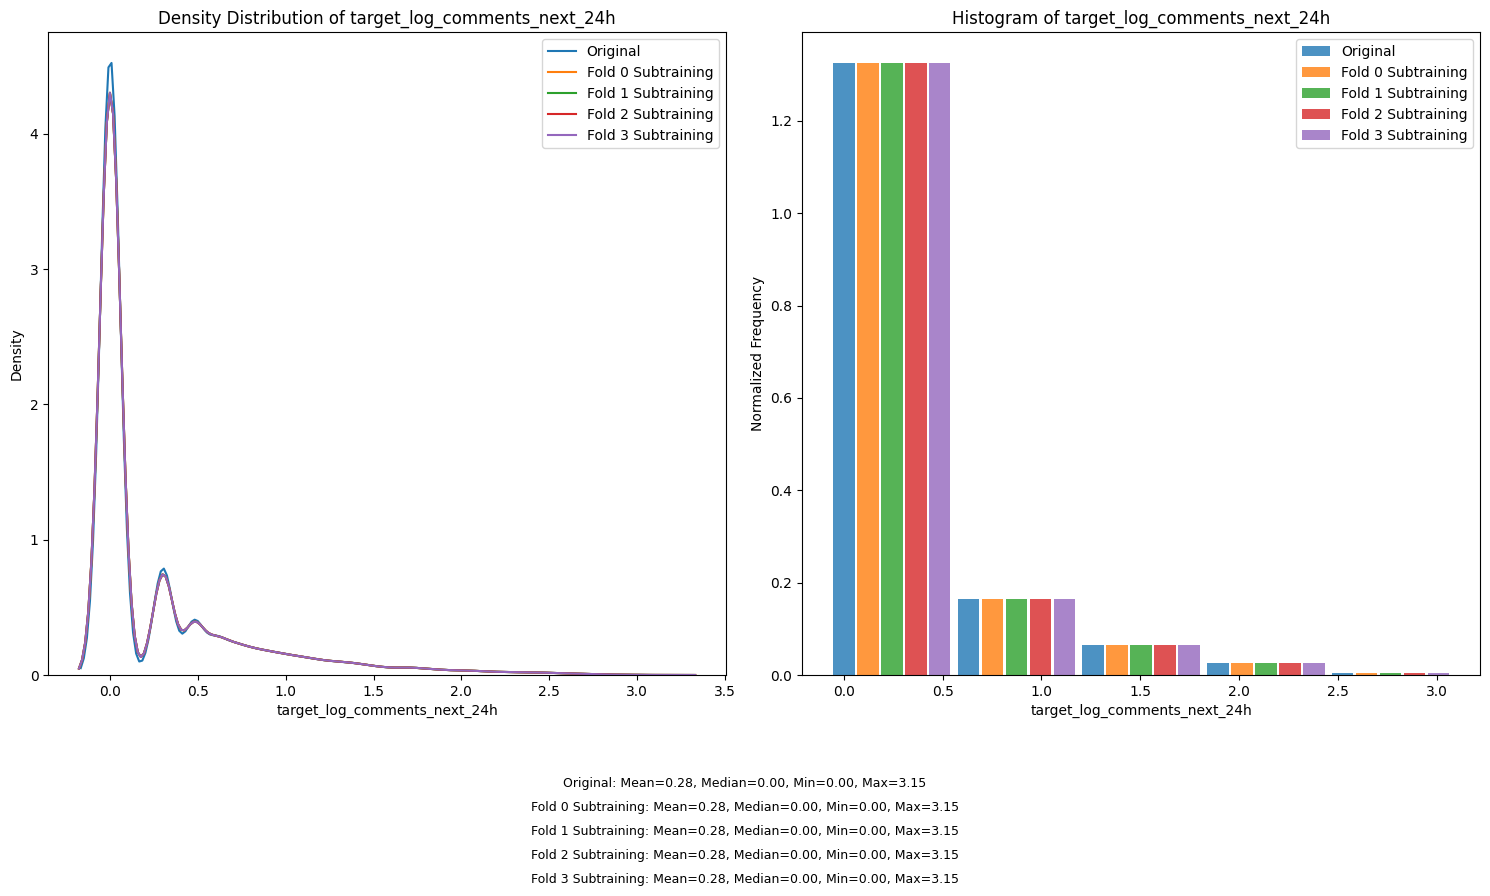

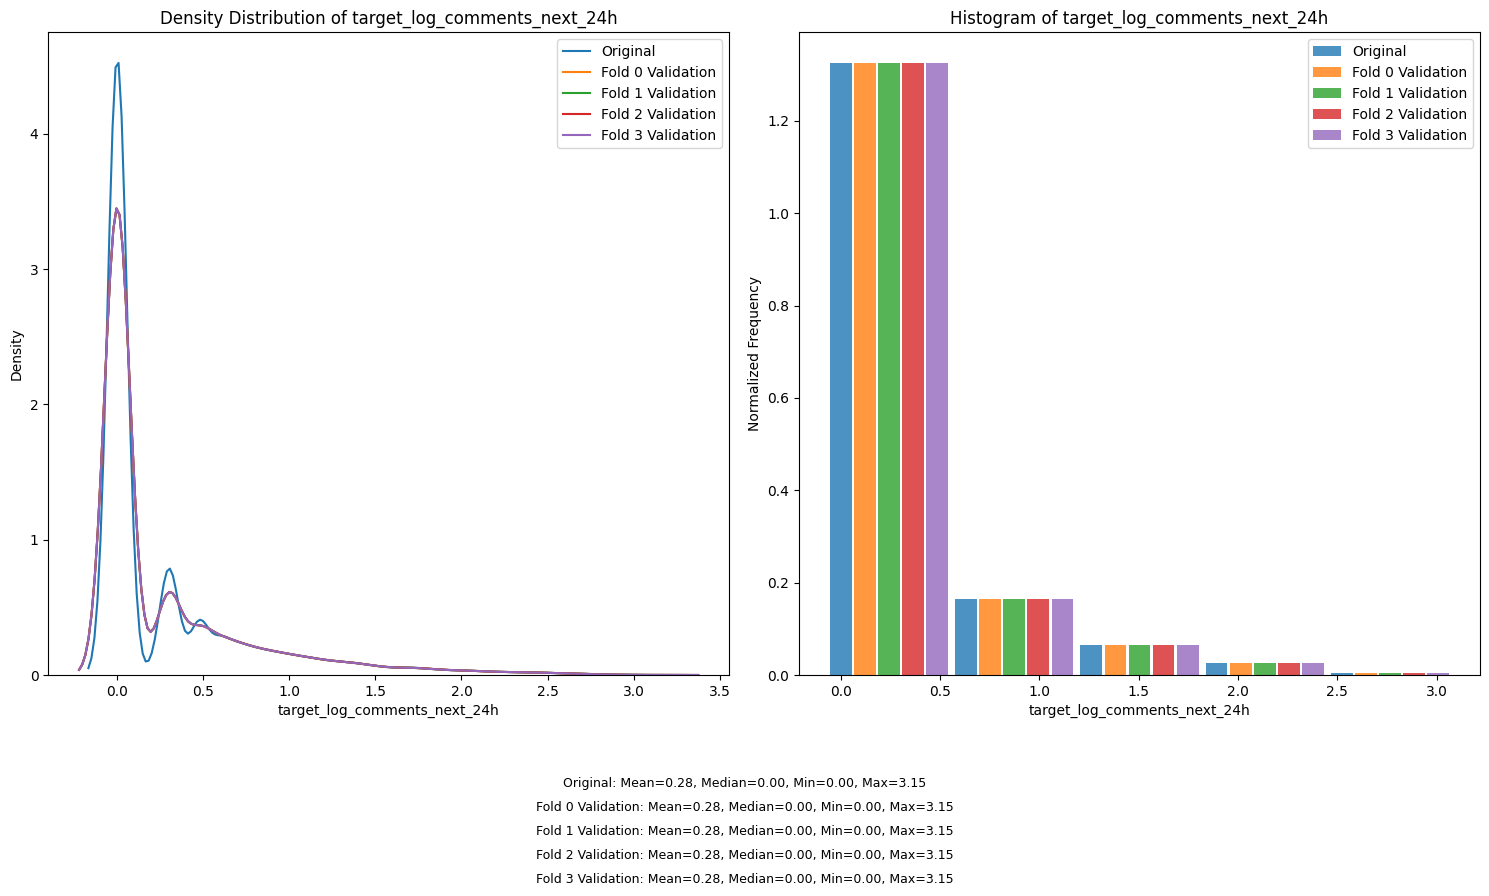


All 4 folds created and saved to C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw


In [83]:
# Create the folds
create_stratified_kfolds(
    df=preprocessed_df_train,  # Your training dataframe
    output_dir=output_dir,  # The directory where to save fold directories
    label_column="target_log_comments_next_24h",
    n_folds=4,
    seed=42
)

In [2]:
def build_blogf_ds(file_path: str, shuffle_data: bool = False, random_state: int = 42) -> tuple:
    """
    Build all blog feedback dataset by loading CSV and splitting into features and label.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file (e.g., 'blogf_training.csv')
    shuffle_data : bool, default=False
        Whether to shuffle the dataset
    random_state : int, default=42
        Random seed for reproducibility when shuffling
        
    Returns:
    --------
    tuple
        X : np.ndarray - Feature columns
        y : np.ndarray - Target variable ('target_log_comments_next_24h')
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Check if the last column is target_log_comments_next_24h as expected
    if df.columns[-1] != "target_log_comments_next_24h":
        print(f"Warning: Expected 'target_log_comments_next_24h' as the last column, found '{df.columns[-1]}' instead")
    
    # Split into features and labels
    X = df.iloc[:, :-1].values  # All columns except the last, as numpy array
    y = df.iloc[:, -1].values   # Just the last column, as numpy array
    
    # Shuffle if requested
    if shuffle_data:
        # Create a shuffled index
        idx = np.arange(len(df))
        np.random.seed(random_state)
        np.random.shuffle(idx)
        
        # Reindex X and y using the shuffled indices
        X = X[idx]
        y = y[idx]
        
        print(f"Data shuffled with random_state={random_state}")
    
    print(f"Dataset built from {file_path}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    
    return X, y

In [85]:

output_dir = os.path.dirname(BLOGF_PATH)
output_path = os.path.join(output_dir, 'blogf_training.csv')
test_output_path = os.path.join(output_dir, 'blogf_testing.csv')

# Build the training dataset
X_train, y_train = build_blogf_ds(output_path, shuffle_data=True, random_state=42)

# Build the testing dataset
X_test, y_test = build_blogf_ds(test_output_path, shuffle_data=False, random_state=42)




Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw\blogf_training.csv
X shape: (52397, 276), y shape: (52397,)
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw\blogf_testing.csv
X shape: (7624, 276), y shape: (7624,)


In [86]:
def load_folds_blogf_ds(
        base_dir: str,
        shuffle: bool = True,
        random_state: Optional[int] = None,
        debug: bool = False
) -> Generator[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray], None, None]:
    """
    Loads pre-split stratified folds from the blog feedback directory structure using build_blogf_ds function
    and yields one fold at a time.

    Directory structure expected:
    base_dir/
        fold0/
            blogf_subtraining.csv
            blogf_validation.csv
        fold1/
            blogf_subtraining.csv
            blogf_validation.csv
        ...

    Parameters:
        base_dir (str): Path to the directory containing the fold directories
        shuffle (bool): Whether to shuffle the data. Default is False.
        random_state (Optional[int]): Random seed for reproducibility. Default is None.
        debug (bool): Whether to enable debug printing. Default is False.

    Yields:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Split feature and label data:
            - X_subtrain: Features for the subtraining set (numpy array)
            - y_subtrain: Labels for the subtraining set (numpy array)
            - X_val: Features for the validation set (numpy array)
            - y_val: Labels for the validation set (numpy array)

    Raises:
        FileNotFoundError: If any expected fold directory or file is missing
    """
    
    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"Base directory not found: {base_dir}")
    
    # Process each fold
    for fold_idx in range(4):
        fold_dir = os.path.join(base_dir, f"fold{fold_idx}")
        
        if not os.path.exists(fold_dir):
            raise FileNotFoundError(f"Missing fold directory: {fold_dir}")
        
        # Path to subtraining and validation files
        subtrain_file = os.path.join(fold_dir, "blogf_subtraining.csv")
        val_file = os.path.join(fold_dir, "blogf_validation.csv")
        
        # Check file existence
        if not os.path.exists(subtrain_file):
            raise FileNotFoundError(f"Missing subtraining file: {subtrain_file}")
        if not os.path.exists(val_file):
            raise FileNotFoundError(f"Missing validation file: {val_file}")
        
        # Load data using build_sep_ds - returns numpy arrays
        X_subtrain, y_subtrain = build_blogf_ds(
            file_path=subtrain_file,
            shuffle_data=shuffle,
            random_state=random_state
        )
        
        X_val, y_val = build_blogf_ds(
            file_path=val_file,
            shuffle_data=shuffle,
            random_state=random_state
        )
        
        if debug:
            print(f"Fold {fold_idx}:")
            print(f"Subtraining shapes: X={X_subtrain.shape}, y={y_subtrain.shape}")
            print(f"Validation shapes: X={X_val.shape}, y={y_val.shape}")
            print(f"Subtraining range: {y_subtrain.min():.4f} to {y_subtrain.max():.4f}")
            print(f"Validation range: {y_val.min():.4f} to {y_val.max():.4f}")
        
        yield X_subtrain, y_subtrain, X_val, y_val

In [87]:
# load the folds
generator = load_folds_blogf_ds(
    base_dir=output_dir,
    shuffle=True,
    random_state=42,
    debug=True
)

# get the first fold
X_subtrain, y_subtrain, X_val, y_val = next(generator)

# print the shapes
print(f"X_subtrain shape: {X_subtrain.shape}, y_subtrain shape: {y_subtrain.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw\fold0\blogf_subtraining.csv
X shape: (39300, 276), y shape: (39300,)
Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/raw\fold0\blogf_validation.csv
X shape: (13100, 276), y shape: (13100,)
Fold 0:
Subtraining shapes: X=(39300, 276), y=(39300,)
Validation shapes: X=(13100, 276), y=(13100,)
Subtraining range: 0.0000 to 3.1538
Validation range: 0.0000 to 3.1538
X_subtrain shape: (39300, 276), y_subtrain shape: (39300,)
X_val shape: (13100, 276), y_val shape: (13100,)


In [101]:
def plot_avsp_blogf(
    model: tf.keras.Model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    title: str,
    prefix: str,
    freq_threshold: float = np.log10(4),
    rare_threshold: float = np.log10(40),
    use_dict: bool = False
) -> str:
    """
    Plots actual vs predicted Torque_1 values.

    Parameters:
    - model (tf.keras.Model): The trained model to evaluate
    - X_test (np.ndarray): Test features
    - y_test (np.ndarray): True target values for the test set
    - title (str): The title of the plot
    - prefix (str): Prefix for the plot file names
    - freq_threshold (float): Frequency threshold - values below this are considered frequent. Default is log10(4)
    - rare_threshold (float): Rare threshold - values above this are considered rare. Default is log10(40)
    - use_dict (bool): Whether the model returns a dictionary with output names. Default is False.

    Returns:
    - str: The absolute path to the saved plot file
    """
    
    # Make predictions
    if use_dict:
        res = model.predict(X_test)
        predictions = res['output']
    else:
        _, predictions = model.predict(X_test)
        
    # Process predictions if needed (flatten if multidimensional)
    predictions = np.array(predictions).flatten()
    y_test = np.array(y_test).flatten()
    
    # Create the figure with proper axes configuration
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Scatter plot with a colormap based on prediction error
    prediction_error = np.abs(y_test - predictions)
    norm = plt.Normalize(np.min(prediction_error), np.max(prediction_error))
    cmap = plt.cm.viridis
    
    scatter = ax.scatter(y_test, predictions, c=prediction_error, cmap=cmap, norm=norm, alpha=0.7, s=40)
    
    # Plot perfect prediction line
    min_intensity = min(np.min(y_test), np.min(predictions))
    max_intensity = max(np.max(y_test), np.max(predictions))
    ax.plot([min_intensity, max_intensity], [min_intensity, max_intensity], 'k--', label='Perfect Prediction')
    
    # Add dashed lines at thresholds on both axes if thresholds are provided
    if freq_threshold is not None:
        ax.axvline(freq_threshold, color='blue', linestyle='--', label='Frequency Threshold')
        ax.axhline(freq_threshold, color='blue', linestyle='--')
    
    if rare_threshold is not None:
        ax.axvline(rare_threshold, color='red', linestyle='--', label='Rare Threshold')
        ax.axhline(rare_threshold, color='red', linestyle='--')
    
    # Add labels and title
    ax.set_xlabel('Actual log_comments_next_24h')
    ax.set_ylabel('Predicted log_comments_next_24h')
    ax.set_title(f"{title}\n{prefix}_Actual_vs_Predicted_log_comments_next_24h")
    
    # Add colorbar for prediction error
    cbar = fig.colorbar(scatter, ax=ax, label='Prediction Error', extend='both')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Highlight regions if thresholds are provided
    if freq_threshold is not None and rare_threshold is not None:
        
        # Add annotations for regions
        ax.annotate('Frequent', xy=(min_intensity, (min_intensity + freq_threshold)/2), 
                   xycoords='data', fontsize=10, color='blue')
        ax.annotate('Medium', xy=((freq_threshold + rare_threshold)/2, (freq_threshold + rare_threshold)/2), 
                   xycoords='data', fontsize=10, color='green')
        ax.annotate('Rare', xy=(rare_threshold + (max_intensity-rare_threshold)/2, rare_threshold + (max_intensity-rare_threshold)/2), 
                   xycoords='data', fontsize=10, color='red')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{title}_{prefix}_actual_vs_predicted_log_comments_next_24h.png"
    plt.savefig(plot_filename)
    plt.close()
    
    return os.path.abspath(plot_filename)

In [102]:
def create_simple_mlp_model(input_shape, hidden_layers=[64, 32], activation='relu', dropout_rate=0.2):
    """
    Create a simple MLP model for regression.
    
    Parameters:
    - input_shape: Shape of input features
    - hidden_layers: List of neurons in each hidden layer
    - activation: Activation function to use
    - dropout_rate: Dropout rate for regularization
    
    Returns:
    - Compiled TensorFlow model
    """
    
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # Add hidden layers
    for units in hidden_layers:
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # This is the representation layer
    representation = x
    
    # Add main output layer (regression - no activation)
    main_output = tf.keras.layers.Dense(1, name="main_output")(x)
    
    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=[representation, main_output])
    model.compile(
        optimizer='adam',
        loss={
            'main_output': 'mse'
        }
    )
    
    return model

# Example usage:
def test_plot_avsp(X_train, y_train, X_test, y_test):
    """
    Train a simple MLP model and test the plot_avsp function.
    
    Parameters:
    - X_train: Training features
    - y_train: Training target values
    - X_test: Test features
    - y_test: Test target values
    
    Returns:
    - Path to the generated plot
    """
    # Create and train model
    input_shape = (X_train.shape[1],)
    model = create_simple_mlp_model(input_shape)
    
    print("Model summary:")
    model.summary()
    
    
    # Generate and save plot
    print("\nGenerating plot...")
    plot_path = plot_avsp_blogf(
        model=model,
        X_test=X_test,
        y_test=y_test,
        title="MLP Model Performance",
        prefix="test_model"
    )
    
    print(f"Plot saved at: {plot_path}")
    return plot_path

In [103]:
plot_path = test_plot_avsp(X_subtrain, y_subtrain, X_val, y_val)
print(plot_path)

Model summary:
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 276)]             0         
                                                                 
 dense_12 (Dense)            (None, 64)                17728     
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                           

In [24]:
def filter_ds(
        X: np.ndarray, y: np.ndarray,
        low_threshold: float, high_threshold: float,
        N: int = 500, bins: int = 10, seed: int = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Filter and sample the dataset based on the threshold values of y with a random seed for reproducibility.

    This function creates a subset of the dataset where all samples where y is either
    below the low_threshold or above the high_threshold are included. Samples where y
    is between the low_threshold and high_threshold are randomly sampled within bins
    to have a total of N samples in the resulting dataset, using a specified seed for
    random number generation.

    Parameters:
        X (np.ndarray): The input features of the dataset.
        y (np.ndarray): The output labels of the dataset.
        low_threshold (float): The lower bound threshold for selecting high delta values.
        high_threshold (float): The upper bound threshold for selecting high delta values.
        N (int): The number of samples to include from the low delta range.
        bins (int): The number of bins to split the low delta range into.
        seed (int, optional): Seed for the random number generator to ensure reproducibility.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The filtered and sampled input features and output labels.
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Flatten the output array to ensure mask works properly with input dimensions
    y_flat = y.flatten()

    # Create a mask to identify high delta samples (below low_threshold or above high_threshold)
    high_deltas_mask = (y_flat <= low_threshold) | (y_flat >= high_threshold)

    # Apply the high deltas mask to get the corresponding samples
    X_high_deltas = X[high_deltas_mask, :]
    y_high_deltas = y[high_deltas_mask, :]

    # Create a mask to identify low delta samples (between low_threshold and high_threshold)
    low_deltas_mask = (y_flat > low_threshold) & (y_flat < high_threshold)

    # Apply the low deltas mask to get the corresponding samples
    X_low_deltas = X[low_deltas_mask, :]
    y_low_deltas = y[low_deltas_mask, :]

    # Create bin edges for the low delta samples
    bins_edges = np.linspace(low_threshold, high_threshold, bins + 1)

    # Digitize y_low_deltas to assign each sample to a bin
    binned_indices = np.digitize(y_low_deltas.flatten(), bins_edges) - 1

    # Determine the budget per bin and remainder
    budget = N // bins
    remainder = N % bins

    # Initialize lists to store sampled low delta values
    X_low_deltas_sampled = []
    y_low_deltas_sampled = []

    # Sample low delta values from each bin
    for bin_idx in range(bins):
        # Create a mask for the current bin
        bin_mask = binned_indices == bin_idx

        # Select samples in the current bin
        X_bin = X_low_deltas[bin_mask, :]
        y_bin = y_low_deltas[bin_mask, :]

        # Determine the number of samples to draw from this bin
        bin_budget = budget + (1 if remainder > 0 else 0)
        remainder = max(0, remainder - 1)

        # Sample from the bin if it has more samples than the budget
        if len(y_bin) > bin_budget:
            sampled_indices = np.random.choice(len(X_bin), size=bin_budget, replace=False)
            X_low_deltas_sampled.append(X_bin[sampled_indices])
            y_low_deltas_sampled.append(y_bin[sampled_indices])
        else:
            # If the bin has fewer samples than the budget, include all samples
            X_low_deltas_sampled.append(X_bin)
            y_low_deltas_sampled.append(y_bin)
            remainder += bin_budget - len(y_bin)

    # Distribute the remaining budget to the center bins
    center_bins = np.arange(bins // 4, 3 * bins // 4)
    for bin_idx in center_bins:
        if remainder <= 0:
            break
        bin_mask = binned_indices == bin_idx
        X_bin = X_low_deltas[bin_mask, :]
        y_bin = y_low_deltas[bin_mask, :]

        if len(y_bin) > len(X_low_deltas_sampled[bin_idx]):
            additional_needed = min(remainder, len(y_bin) - len(X_low_deltas_sampled[bin_idx]))
            sampled_indices = np.random.choice(
                np.arange(len(y_bin)),
                size=additional_needed,
                replace=False
            )
            X_low_deltas_sampled[bin_idx] = np.concatenate((X_low_deltas_sampled[bin_idx], X_bin[sampled_indices]))
            y_low_deltas_sampled[bin_idx] = np.concatenate((y_low_deltas_sampled[bin_idx], y_bin[sampled_indices]))
            remainder -= additional_needed

    # Concatenate all sampled low delta values
    X_low_deltas_sampled = np.concatenate(X_low_deltas_sampled, axis=0)
    y_low_deltas_sampled = np.concatenate(y_low_deltas_sampled, axis=0)

    # Combine high delta samples with sampled low delta samples
    X_combined = np.concatenate([X_high_deltas, X_low_deltas_sampled], axis=0)
    y_combined = np.concatenate([y_high_deltas, y_low_deltas_sampled], axis=0)

    return X_combined, y_combined

In [104]:
# find the kde such that ratio is maintained on the training set
training_path = 'C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_training.csv'

# build training set
X_train, y_train = build_blogf_ds(training_path, shuffle_data=True, random_state=42)

Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_training.csv
X shape: (52397, 276), y shape: (52397,)


In [106]:
def analyze_label_dist_with_kde(y: np.ndarray, kde_bandwidth: float = 0.1, bin_width: float = 10) -> float:
    """
    Analyze label distribution with histogram and KDE overlay, and calculate density ratios.
    
    Parameters:
    -----------
    y : np.ndarray
        The array of label values to analyze
    kde_bandwidth : float, default=0.1
        The bandwidth parameter for KDE
    bin_width : float, default=10
        The width of each histogram bin
        
    Returns:
    --------
    float
        KDE density_ratio: The ratio between highest and lowest non-zero density
    """
    # Find minimum and maximum values in the array
    min_y_value = np.min(y)
    max_y_value = np.max(y)
    
    # Calculate number of bins based on bin_width
    range_y = max_y_value - min_y_value
    num_bins = int(np.ceil(range_y / bin_width))
    
    # Create a histogram to find the frequencies
    counts, bins = np.histogram(y, bins=num_bins)
    
    # Find the minimum and maximum frequencies and their corresponding values
    min_freq = np.min(counts[counts > 0])  # Minimum non-zero frequency
    max_freq = np.max(counts)
    
    # Find the bin indices for min and max frequencies
    min_freq_idx = np.where(counts == min_freq)[0][0]
    max_freq_idx = np.where(counts == max_freq)[0][0]
    
    # Get the corresponding y values (using bin centers)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    min_freq_value = bin_centers[min_freq_idx]
    max_freq_value = bin_centers[max_freq_idx]

    # Calculate ratio between min and max frequencies
    freq_ratio = max_freq / min_freq if min_freq > 0 else float('inf')
    
    # Print the key frequency information
    print(f'Value with min frequency: {min_freq_value:.4f}, Frequency: {min_freq}')
    print(f'Value with max frequency: {max_freq_value:.4f}, Frequency: {max_freq}')
    print(f'Frequency ratio (max/min): {freq_ratio:.4f}')
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram in blue
    counts, bins, _ = plt.hist(y, bins=num_bins, alpha=0.6, color='blue', label=f'Histogram (bin width={bin_width})')
    
    # Compute KDE with specified bandwidth
    kde = gaussian_kde(y, bw_method=kde_bandwidth)
    
    # Generate points for plotting KDE
    x_grid = np.linspace(min_y_value - 0.5, max_y_value + 0.5, 1000)
    density = kde(x_grid)
    
    # Scale KDE to match histogram height for better visualization
    scale_factor = np.max(counts) / np.max(density)
    scaled_density = density * scale_factor
    
    # Plot scaled KDE in orange
    plt.plot(x_grid, scaled_density, color='orange', linewidth=2, label=f'KDE (bw={kde_bandwidth})')
    
    # Calculate KDE density ratio
    non_zero_density = density[density > 1e-10]
    max_density = np.max(non_zero_density)
    min_density = np.min(non_zero_density)
    density_ratio = max_density / min_density
    
    # Print KDE density information
    print(f'Min density: {min_density:.10f}')
    print(f'Max density: {max_density:.10f}')
    print(f'KDE density ratio (max/min): {density_ratio:.4f}')
    
    # Add ratio text to plot
    plt.text(0.05, 0.95, f'KDE density ratio: {density_ratio:.2f}\nFreq ratio: {freq_ratio:.2f}', 
            transform=plt.gca().transAxes, fontsize=12, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Set title and labels
    plt.title('Label Distribution with KDE Overlay')
    plt.xlabel('Label Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return density_ratio

Value with min frequency: 3.0306, Frequency: 1
Value with max frequency: 0.0246, Frequency: 33559
Frequency ratio (max/min): 33559.0000
Min density: 0.0000314843
Max density: 1.0628674467
KDE density ratio (max/min): 33758.6224


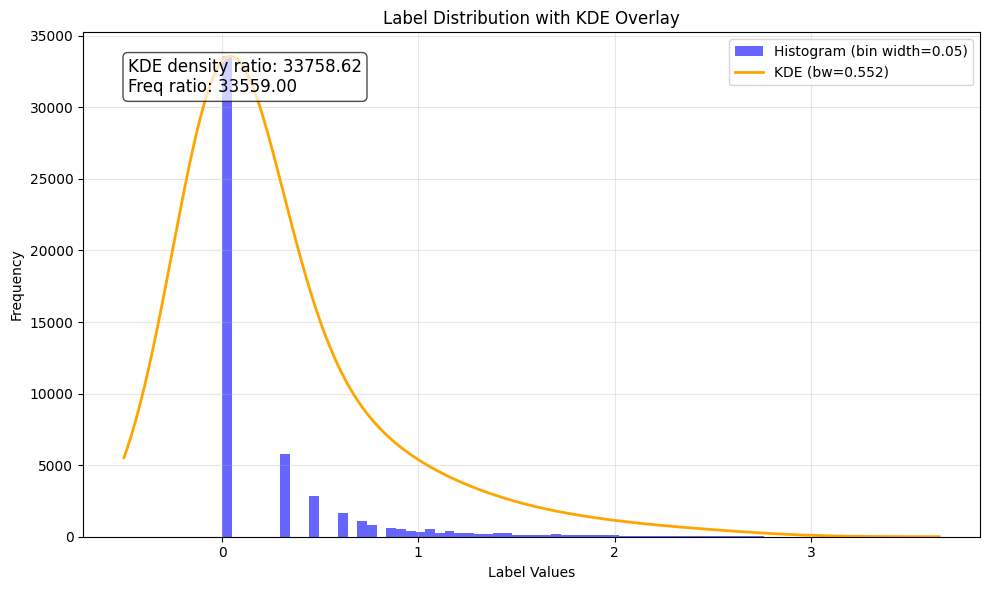

33758.622359504974

In [120]:
analyze_label_dist_with_kde(y_train, 0.552, bin_width=0.05)

In [3]:
# find the kde such that ratio is maintained on the training set
training_path = 'C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_training.csv'
test_path = 'C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_testing.csv'

# build training set
X_train, y_train = build_blogf_ds(training_path, shuffle_data=True, random_state=42)
X_test, y_test = build_blogf_ds(test_path, shuffle_data=True, random_state=42)

# Combine training and testing data for analysis
y_combined = np.concatenate([y_train, y_test])

lower_threshold = np.log10(4)
upper_threshold = np.log10(40)

# Calculate the percentage of samples in different ranges
below_lower_threshold = np.sum(y_combined < lower_threshold) / len(y_combined) * 100
between_lower_and_upper_threshold = np.sum((y_combined >= lower_threshold) & (y_combined <= upper_threshold)) / len(y_combined) * 100
above_upper_threshold = np.sum(y_combined > upper_threshold) / len(y_combined) * 100

# Print the results
print(f"Percentage of samples below {lower_threshold}: {below_lower_threshold:.2f}%")
print(f"Percentage of samples between {lower_threshold} and {upper_threshold}: {between_lower_and_upper_threshold:.2f}%")
print(f"Percentage of samples above {upper_threshold}: {above_upper_threshold:.2f}%")

# Verify that percentages sum to 100%
total = below_lower_threshold + between_lower_and_upper_threshold + above_upper_threshold
print(f"Total percentage: {total:.2f}%")

Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_training.csv
X shape: (52397, 276), y shape: (52397,)
Data shuffled with random_state=42
Dataset built from C:/Users/the_3/Documents/github/keras-functional-api/data/blog_feedback/blogf_testing.csv
X shape: (7624, 276), y shape: (7624,)
Percentage of samples below 0.6020599913279624: 80.81%
Percentage of samples between 0.6020599913279624 and 1.6020599913279623: 15.86%
Percentage of samples above 1.6020599913279623: 3.33%
Total percentage: 100.00%
